<h1>Analysis of the SOM maps Order Time, Cuisin Preference and Order Volumes</h1>

I'll analyze these Self-Organizing Maps (SOMs) which appear to be visualizing data from what seems to be a food service or restaurant business. Let me break down the analysis by each image:

Image 1 - Temporal Order Patterns:
- Shows order distribution across different times of day
- Morning orders have several hotspots (red areas), suggesting multiple peak times during breakfast
- Midday orders show a more concentrated pattern of high activity
- Evening orders display the highest intensity (note the scale goes to 25)
- Night orders are generally lower (scale only to 8) with a few scattered hotspots
- Drinking orders have a distinct isolated hotspot, suggesting a specific peak time or location for beverage orders

Image 2 - Cuisine and Category Analysis:
- Shows different cuisine types and food categories with their clustering patterns
- Japanese cuisine shows a strong concentrated hotspot (scale up to 120)
- Chinese and Indian cuisines have moderate intensity clusters
- Thai cuisine shows a more diffused pattern
- The "CUI_Asian" category shows the highest scale (up to 250), suggesting it might be an aggregated category
- Beverages show multiple hotspots at different locations
- Street Food/Snacks category shows significant variation in intensity
- Desserts and Cafe categories have distinct clustering patterns

Image 3 - Business Metrics:
- Vendor count shows a concentrated hotspot (scale up to 120), suggesting a dense cluster of vendors in a specific area
- Product count displays a moderate concentration with surrounding influence
- Total spending shows a broader, more diffused pattern with multiple high-value areas
- Total orders shows a focused hotspot with radiating influence

Key Insights:
1. There are distinct temporal patterns in ordering behavior, with evening being the busiest period
2. Asian cuisines, particularly Japanese, seem to be significant in the dataset
3. There's a clear geographical or categorical clustering of vendors
4. Spending patterns are more dispersed than order patterns, suggesting varying price points across locations or categories

These SOMs reveal underlying patterns in the data that could be valuable for:
- Optimizing staffing across different times of day
- Understanding cuisine popularity and distribution
- Identifying potential areas for business expansion
- Managing vendor and product distributions efficiently

Would you like me to dive deeper into any particular aspect of this analysis?

In [2]:
from os.path import join
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#from sklearn.cluster import KMeans, AgglomerativeClustering
#from sklearn.neighbors import KNeighborsClassifier

from minisom import MiniSom

In [3]:
## Import Matplotlib functions to create MiniSOM visualizations

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.lines import Line2D
import seaborn as sns

from matplotlib import __version__ as mplver

In [3]:
df = pd.read_csv(join('..', 'data', 'processed_ABCDEats_data.csv'))
df.head()

,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,...,weekend_ratio,lunch_orders,dinner_orders,meal_preference,morning_orders,midday_orders,evening_orders,night_orders,drinking_orders,primary_time_period
0,1b8f824d5e,2360,18,2,5,1,0,1,DELIVERY,DIGI,...,1.0,0,2,dinner,0,0,2,0,0,evening
1,5d272b9dcb,8670,17,2,2,2,0,1,DISCOUNT,DIGI,...,1.0,1,0,lunch,1,1,0,0,0,morning
2,f6d1b2ba63,4660,38,1,2,2,0,1,DISCOUNT,CASH,...,1.0,1,0,lunch,1,1,0,0,0,morning
3,180c632ed8,4660,24,2,3,1,0,2,DELIVERY,DIGI,...,0.5,1,0,lunch,0,2,0,0,0,midday
4,4eb37a6705,4660,20,2,5,0,0,2,-,DIGI,...,0.5,0,0,dinner,2,0,0,0,0,morning


In [11]:
def plot_hexagons(som,              # Trained SOM model 
                  sf,               # matplotlib figure object
                  colornorm,        # colornorm
                  matrix_vals,      # SOM weights or
                  label="",         # title for figure
                  cmap=cm.Grays,    # colormap to use
                  annot=False       
                  ):

    
    axs = sf.subplots(1,1)
    
    for i in range(matrix_vals.shape[0]):
        for j in range(matrix_vals.shape[1]):

            wx, wy = som.convert_map_to_euclidean((i,j)) 

            hex = RegularPolygon((wx, wy), 
                                numVertices=6, 
                                radius= np.sqrt(1/3),
                                facecolor=cmap(colornorm(matrix_vals[i, j])), 
                                alpha=1, 
                                edgecolor='white',
                                linewidth=.5)
            axs.add_patch(hex)
            if annot==True:
                annot_val = np.round(matrix_vals[i,j],2)
                if int(annot_val) == annot_val:
                    annot_val = int(annot_val)
                axs.text(wx,wy, annot_val, 
                        ha='center', va='center', 
                        fontsize='x-small')


    ## Remove axes for hex plot
    axs.margins(.05)
    axs.set_aspect('equal')
    axs.axis("off")
    axs.set_title(label)

    

    # ## Add colorbar
    divider = make_axes_locatable(axs)
    ax_cb = divider.append_axes("right", size="5%", pad="0%")

    ## Create a Mappable object
    cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
    cmap_sm.set_array([])

    ## Create custom colorbar 
    cb1 = colorbar.Colorbar(ax_cb,
                            orientation='vertical', 
                            alpha=1,
                            mappable=cmap_sm
                            )
    cb1.ax.get_yaxis().labelpad = 6

    # Add colorbar to plot
    sf.add_axes(ax_cb)




    return sf 

<h1>Order Time Features</h1>

In [27]:
order_time_features = [
    'morning_orders', 'midday_orders', 'evening_orders', 'night_orders', 'drinking_orders'
]
order_time_features

['morning_orders',
 'midday_orders',
 'evening_orders',
 'night_orders',
 'drinking_orders']

In [28]:
# M = 0
# N = 0
# neighborhood_function = None 
# topology = None 
# n_feats = len(metric_features)
# learning_rate = None

M = 15
N = 15
neighborhood_function = 'gaussian' 
topology = 'hexagonal' 
n_feats = len(order_time_features)
learning_rate = .7


som_data = df[order_time_features].values

sm = MiniSom(M, N,              # 10x10 map size
             n_feats,           # Number of the elements of the vectors in input.
             learning_rate=learning_rate, 
             topology=topology, 
             neighborhood_function=neighborhood_function, 
             activation_distance='euclidean',
             random_seed=42
             )

# Initializes the weights of the SOM picking random samples from data.
sm.random_weights_init(som_data) 


print("Before training:")
print("QE", np.round(sm.quantization_error(som_data),4))
print("TE", np.round(sm.topographic_error(som_data),4))



# Trains the SOM using all the vectors in data sequentially
# minisom does not distinguish between unfolding and fine tuning phase;

sm.train_batch(som_data, 20000)

print("After training:")
print("QE", np.round(sm.quantization_error(som_data),4))
print("TE", np.round(sm.topographic_error(som_data),4))


Before training:
QE 0.6927
TE 0.9718
After training:
QE 0.4518
TE 0.212


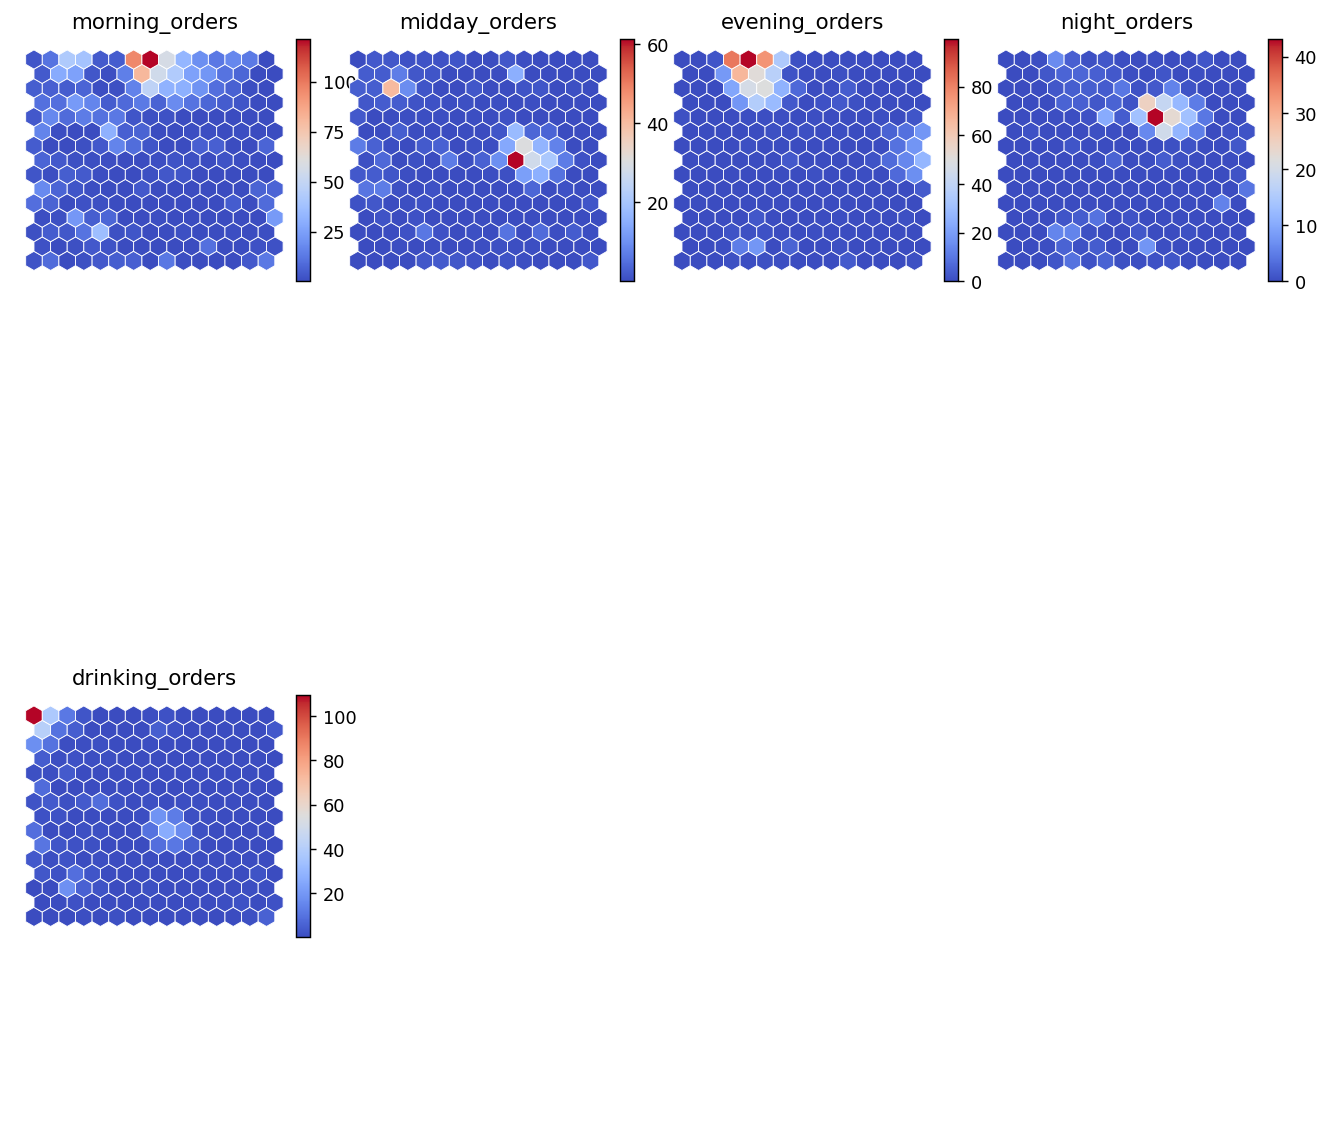

In [29]:
##############################
# Plot Component Planes
##############################

figsize=(10, 10)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

subfigs = fig.subfigures(2,4,wspace=.05, hspace=.05)

colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi, sf in zip(range(len(order_time_features)), subfigs.flatten()):
    
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    # colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=order_time_features[cpi],
                    cmap=cm.coolwarm,
                    )

The `umatrix` function generates a Unified Distance Matrix (U-Matrix) for a Self-Organizing Map (SOM).
The U-Matrix visualizes the distances between neighboring neurons in the SOM.
In the resulting figure, each cell represents a neuron, and the color intensity indicates the distance to its neighboring neurons. Higher values (darker colors) indicate larger distances, suggesting cluster boundaries,
while lower values (lighter colors) indicate smaller distances, suggesting similar or closely related neurons.

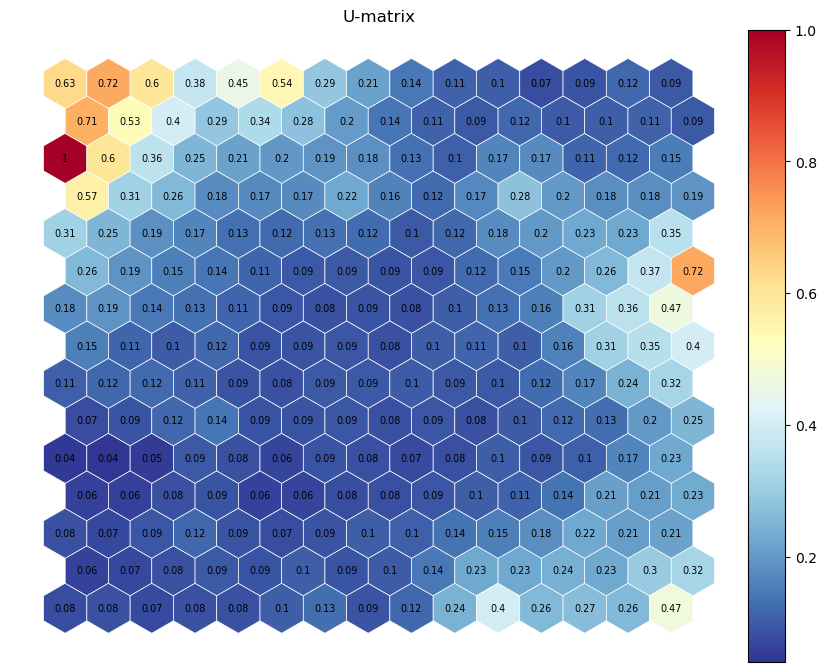

In [13]:
umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r,
                    annot=True
                    )

<h3>U-matrix interpretation</h3>
Color Gradient:
	•	Dark Blue Areas: Represent regions with low distances between neighboring neurons, indicating high similarity (clusters).<br>
	•	Yellow/Orange/Red Areas: Represent regions with high distances, indicating boundaries between clusters or dissimilar regions.<br>
	2.	Clusters:<br>
	•	Clear clusters can be seen in the dark blue regions surrounded by higher-distance (lighter yellow/red) boundaries.<br>
	•	The red region (1.0) at the top-left indicates a highly distinct point with unique patterns in the data. This could represent a specific behavior or group of customers with exceptional ordering times.<br>
	3.	Customer Segmentation:<br>
	•	Customers represented by similar neurons (blue clusters) likely exhibit similar ordering times or behaviors.<br>
	•	The red and yellow boundary areas (e.g., near 0.72, 0.6) suggest outlier customer behaviors that are worth further investigation.<br>
<h4>Insights and Marketing Strategies for Sales Improvements:</h4>
	1.	Target High-Value Segments:<br>
	•	Investigate the distinct red cluster (1.0) and boundary regions (yellow/orange zones). These could represent high-value customers or special-order scenarios.<br>
	•	Develop personalized strategies for these customers, such as tailored promotions or discounts.<br>
	2.	Understand Patterns in Similar Segments:<br>
	•	The large dark blue regions indicate a major cluster of customers with consistent behaviors.<br>
	•	These could be regular buyers with predictable ordering habits. Use this to improve demand forecasts and optimize inventory.

### SOM Hits Map

The SOM Hits Map visualizes the number of times each neuron in the Self-Organizing Map (SOM) has been activated or "hit" by the input data. Each cell in the map represents a neuron, and the color intensity indicates the number of hits. Higher values (darker colors) indicate neurons that have been activated more frequently, suggesting that these neurons represent more common patterns in the data.

#### Key Points:
- **Neurons**: Each hexagon represents a neuron in the SOM.
- **Color Intensity**: The color intensity of each hexagon indicates the number of hits. Darker colors represent higher hit counts.
- **Clusters**: Areas with high hit counts may indicate clusters or common patterns in the data.
- **Interpretation**: By analyzing the hits map, we can identify which neurons are most representative of the input data and understand the distribution of patterns across the SOM.

This visualization helps in understanding the density and distribution of the data points in the SOM, providing insights into the underlying structure and patterns in the dataset.

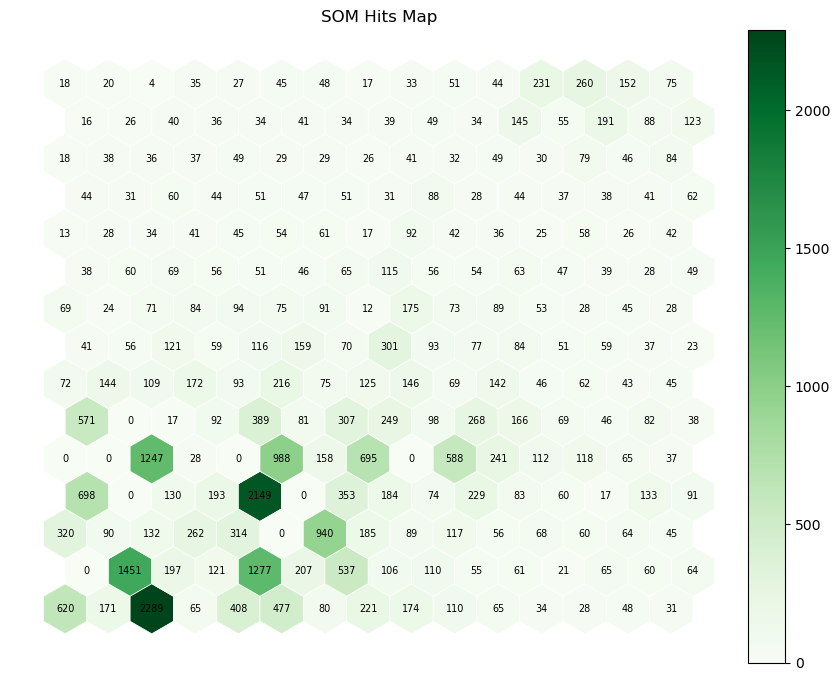

In [14]:
hitsmatrix = sm.activation_response(df[order_time_features].values)


fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hitsmatrix,
                    label="SOM Hits Map",
                    cmap=cm.Greens,
                    annot=True
                    )


<h4>Hits Map interpretation</h4>
	1.	High-Density Regions:<br>
	•	Hexagons with dark green colors and large numeric values (e.g., 2289, 2149, 1451, 1277) represent clusters with a high number of data points.<br>
	•	These regions indicate popular customer behaviors or dominant patterns in ordering times.<br>
	2.	Low-Density Regions:<br>
	•	Light green hexagons and small numeric values indicate fewer hits or sparse regions. These could represent:<br>
	•	Unique ordering patterns.<br>
	•	Less frequent behaviors or outliers.<br>
	•	Notably, hexagons with zero hits represent neurons where no data points are mapped, suggesting unutilized regions of the SOM.<br>
	3.	Cluster Structure:<br>
	•	Dense clusters (e.g., bottom-middle regions) are surrounded by regions of lower density. This suggests that most of the data points align with a few dominant patterns in ordering time.<br>
	•	Sparse regions (top and sides) highlight divergent or outlier behaviors.

## Clustering with SOMs: K-means SOM vs Emergent SOM
- In **k-means SOM**, the *number of units should be equal to the expected number of clusters*, and thus each cluster should be represented by a single unit. 
- In **emergent SOM**, a very *large number of units is used*. These very large SOM allow for very clear U-Matrices and are useful for detecting quite clearly the underlying structure of the data. This technique can be **used together with other clustering algorithms**.

<h1>Cuisine Preference Clustering</h1>

In [21]:
cui_features = ['CUI_Japanese', 'CUI_Chinese', 'CUI_Indian', 'CUI_Thai', 'CUI_Desserts', 'CUI_Cafe', 'CUI_Street Food / Snacks', 'CUI_Beverages','CUI_Asian','CUI_OTHER']

In [22]:
# M = 0
# N = 0
# neighborhood_function = None 
# topology = None 
# n_feats = len(metric_features)
# learning_rate = None

M = 15
N = 15
neighborhood_function = 'gaussian' 
topology = 'hexagonal' 
n_feats = len(cui_features)
learning_rate = .7


som_data = df[cui_features].values

sm = MiniSom(M, N,              # 10x10 map size
             n_feats,           # Number of the elements of the vectors in input.
             learning_rate=learning_rate, 
             topology=topology, 
             neighborhood_function=neighborhood_function, 
             activation_distance='euclidean',
             random_seed=42
             )

# Initializes the weights of the SOM picking random samples from data.
sm.random_weights_init(som_data) 


print("Before training:")
print("QE", np.round(sm.quantization_error(som_data),4))
print("TE", np.round(sm.topographic_error(som_data),4))



# Trains the SOM using all the vectors in data sequentially
# minisom does not distinguish between unfolding and fine tuning phase;

sm.train_batch(som_data, 20000)

print("After training:")
print("QE", np.round(sm.quantization_error(som_data),4))
print("TE", np.round(sm.topographic_error(som_data),4))


Before training:
QE 6.4611
TE 0.9918
After training:
QE 5.0998
TE 0.2738


In [23]:
##############################
# Plot Component Planes
##############################

figsize=(10, 10)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

subfigs = fig.subfigures(4,3,wspace=.08, hspace=.07)

colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi, sf in zip(range(len(cui_features)), subfigs.flatten()):
    
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    # colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=cui_features[cpi],
                    cmap=cm.coolwarm,
                    )

NameError: name 'weights' is not defined

<Figure size 1280x1280 with 0 Axes>

<h1>Order Volume Features</h1>

In [22]:
order_volume_features = ['vendor_count', 'product_count', 'total_spending', 'total_orders']

In [23]:
# M = 0
# N = 0
# neighborhood_function = None 
# topology = None 
# n_feats = len(metric_features)
# learning_rate = None

M = 15
N = 15
neighborhood_function = 'gaussian' 
topology = 'hexagonal' 
n_feats = len(order_volume_features)
learning_rate = .7


som_data = df[order_volume_features].values

sm = MiniSom(M, N,              # 10x10 map size
             n_feats,           # Number of the elements of the vectors in input.
             learning_rate=learning_rate, 
             topology=topology, 
             neighborhood_function=neighborhood_function, 
             activation_distance='euclidean',
             random_seed=42
             )

# Initializes the weights of the SOM picking random samples from data.
sm.random_weights_init(som_data) 


print("Before training:")
print("QE", np.round(sm.quantization_error(som_data),4))
print("TE", np.round(sm.topographic_error(som_data),4))



# Trains the SOM using all the vectors in data sequentially
# minisom does not distinguish between unfolding and fine tuning phase;

sm.train_batch(som_data, 20000)

print("After training:")
print("QE", np.round(sm.quantization_error(som_data),4))
print("TE", np.round(sm.topographic_error(som_data),4))



Before training:
QE 2.6214
TE 0.9657
After training:
QE 1.8135
TE 0.4339


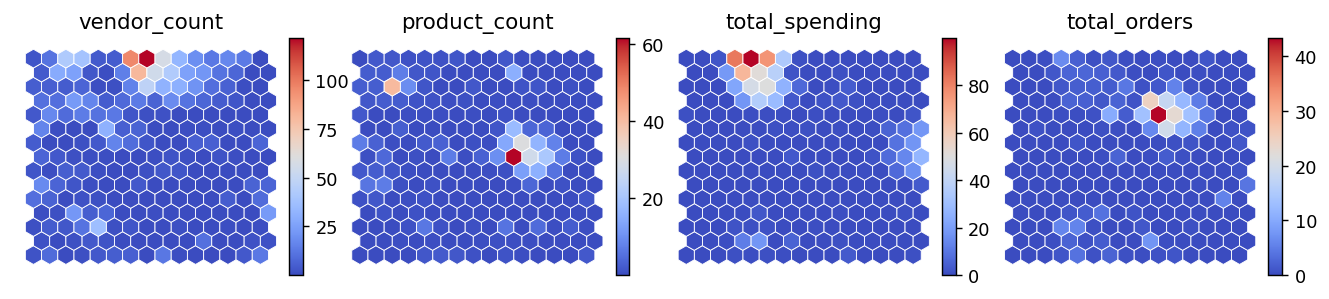

In [25]:
##############################
# Plot Component Planes
##############################

figsize=(10, 10)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

subfigs = fig.subfigures(1,4,wspace=.08, hspace=.07)

colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi, sf in zip(range(len(order_volume_features)), subfigs.flatten()):
    
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    # colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=order_volume_features[cpi],
                    cmap=cm.coolwarm,
                    )

Concrete Expansion Recommendation:
Launch an "Asian Fusion Dining & Bar Concept" with these specific characteristics:

Location Strategy:


Target areas where there's high total_spending (from Image 3) but lower vendor_count
Look for zones where the hotspots in total_spending don't perfectly align with vendor_count hotspots, indicating underserved high-value areas


Service Mix:


Primary Focus: Evening dining service (capitalize on the highest order intensity)
Secondary Focus: Lunch service (leverage midday order patterns)
Include a dedicated bar component (based on drinking_orders pattern)


Menu Strategy:


Core offering: Fusion dishes combining elements from Japanese, Chinese, and Thai cuisines
Premium pricing strategy (supported by total_spending patterns)
Include a strong beverage program (based on CUI_Beverages patterns)


Specific Operational Recommendations:


Operating Hours: Heavy staffing from 5PM-10PM (evening orders peak)
Secondary staffing peak for lunch rush
Bar program focused on peak drinking_orders times
Consider a smaller late-night menu (based on night_orders patterns)

<h2>Demographic Perspective:</h2>Not applicable, bcs categorical
<p>Understanding the demographic distribution helps in tailoring marketing strategies and operational decisions. Here's a breakdown:</p><br>
- City: High spending areas with dense populations and diverse culinary preferences.<br>
- Suburban: Moderate spending with a mix of family-oriented and individual orders.<br>
- Coastal: Seasonal spending peaks, often influenced by tourism and local events.<br>